### Star detection using GAIA DR3 cross matching


Procesando archivo: 111_Altair_v2.fits


Set OBSGEO-Y to -6113855.608 from OBSGEO-[LBH].
Set OBSGEO-Z to   509176.883 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


INFO: Query finished. [astroquery.utils.tap.core]
....
Se encontraron 10000 objetos en total
....
Aplicando filtro de Magnitudes mas brillantes que 11.99
....
....
Se encontraron 14 objetos
....


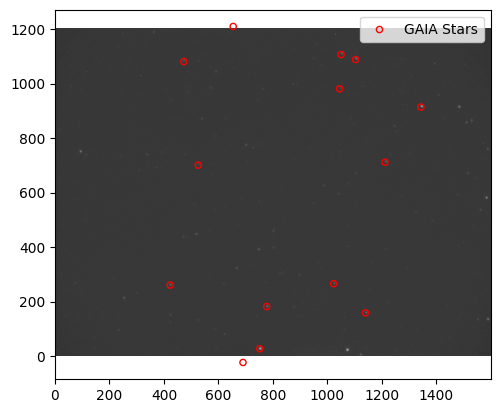

Coordenadas centrales: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (297.88824097, 8.89849159)>


In [160]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia


# Definir el parámetro de escala o tamaño de la placa
scale = 0.822 * u.arcsec  # ascsec/px pixel scale se obtiene de la astrometria

# Open the FITS file con astrometria
file_path = "111_Altair_v2.fits"
print(f"Procesando archivo: {file_path}")

# Cargar los datos de la imagen FITS
hdul = fits.open(file_path)
image_data = hdul[0].data
header = hdul[0].header
wcs = WCS(header)

# Obtener las coordenadas del centro de la imagen
ny, nx = image_data.shape
center_x = nx / 2
center_y = ny / 2
center_coord = wcs.pixel_to_world(center_x, center_y)

# Definir el tamaño del rectángulo de búsqueda
pixel_width = nx * scale
pixel_height = ny * scale
width = u.Quantity(pixel_width, u.deg)
height = u.Quantity(pixel_height, u.deg)

# Realizar la consulta al catálogo GAIA
Gaia.ROW_LIMIT = 10000
j = Gaia.query_object_async(coordinate=center_coord, width=width, height=height);

# Convertir a pandas para trabajar con los datos de manera más cómoda
results_GAIA = j.to_pandas()
print("....")
print(f"Se encontraron {len (results_GAIA)} objetos en total")
print("....")
# Aplicar un filtro para la cantidad de objetos obtenidos
filtered_stars = results_GAIA[results_GAIA["phot_g_mean_mag"] < 12]
print(f"Aplicando filtro de Magnitudes mas brillantes que {np.max(filtered_stars['phot_g_mean_mag']):.2f}")
print("....")
print("....")
print(f"Se encontraron {len (filtered_stars)} objetos")
print("....")

# Obtener las coordenadas de RA y Dec
ra = filtered_stars["ra"]
dec = filtered_stars["dec"]

# Convertir las coordenadas de GAIA a píxeles en la imagen
gaia_coords = SkyCoord(ra=ra.values, dec=dec.values, unit=(u.deg, u.deg))
x_star, y_star = wcs.world_to_pixel(gaia_coords)

# Mostrar la imagen FITS con los puntos encontrados
norm = simple_norm(image_data, "sqrt")

plt.imshow(image_data, cmap="gray", norm=norm, origin="lower")  # Usar PowerNorm para el escalado logarítmico
plt.scatter(x_star, y_star, s=20, edgecolor="red", facecolor="none", label="GAIA Stars")  # Ajustar el tamaño y color de los puntos
plt.legend()
plt.show()
print(f"Coordenadas centrales: {center_coord}")

In [161]:
data = {
    "source_id": filtered_stars["SOURCE_ID"],
    "RA": ra,
    "Dec": dec,
    "x": x_star,
    "y": y_star,
}
df_stars = pd.DataFrame(data)
list_stars = df_stars.to_dict("records")
#df_stars

Estrella con FWHM (diametro) = 12.16


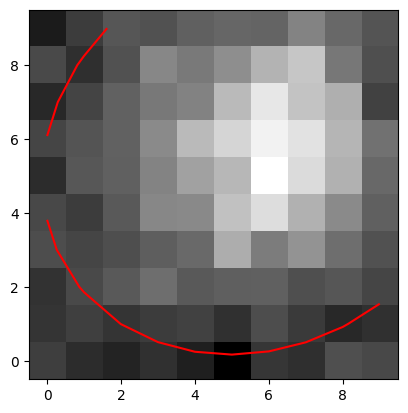

Estrella con FWHM (diametro) = 9.95


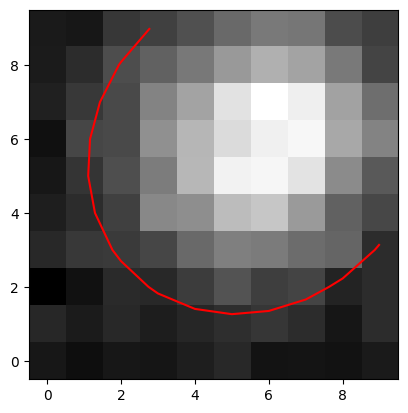

Estrella con FWHM (diametro) = 8.67


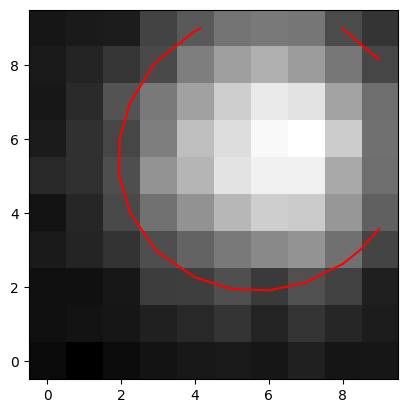

Estrella con FWHM (diametro) = 8.41


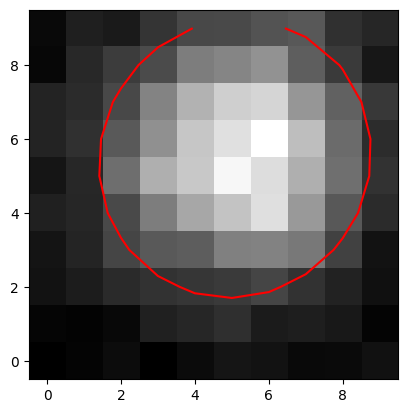

Estrella con FWHM (diametro) = 12.35


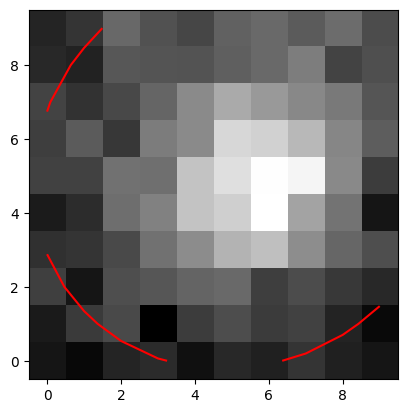

Estrella con FWHM (diametro) = 8.84


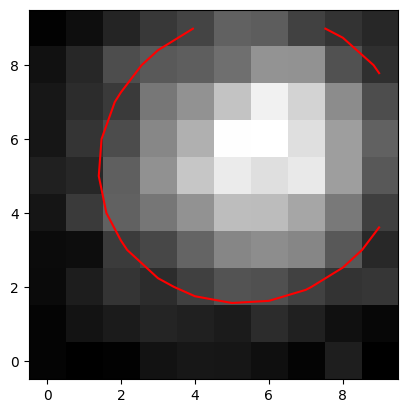

Estrella con FWHM (diametro) = 8.46


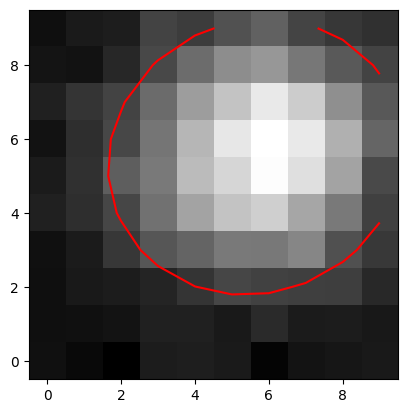

Estrella con FWHM (diametro) = 7.63


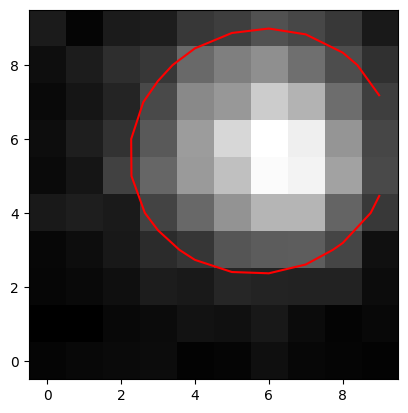

Estrella con FWHM (diametro) = 6.26


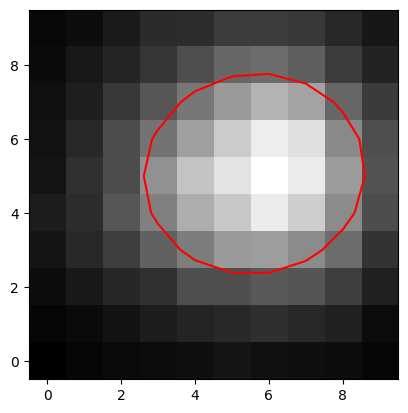

Estrella con FWHM (diametro) = 6.73


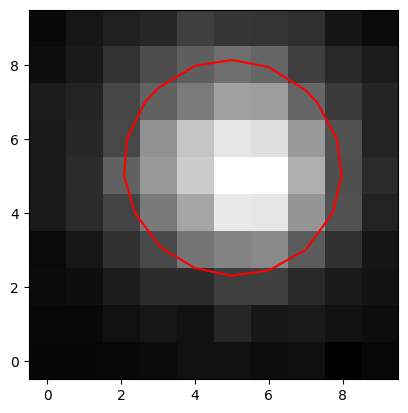

Estrella con FWHM (diametro) = 8.63


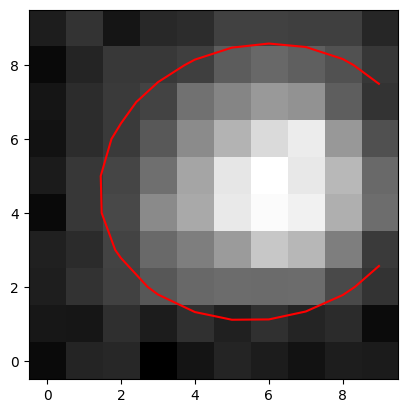

Estrella con FWHM (diametro) = 5.71


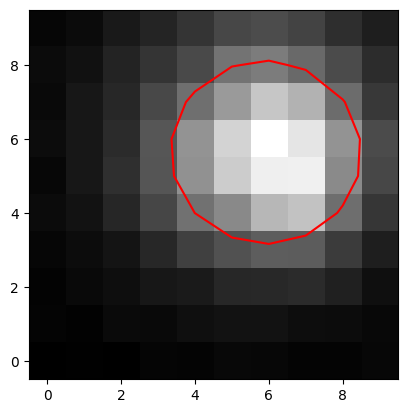

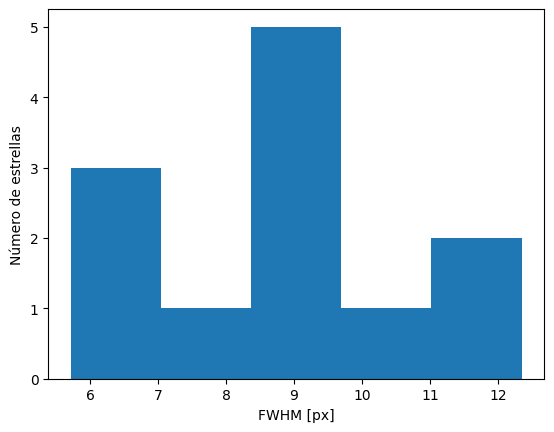

In [165]:
# Definir el ajuste Gaussiano 2D y el fitting
fit_p = fitting.LevMarLSQFitter()
diameter_gaia = []
# Calcular el FWHM para cada estrella detectada
for star in list_stars:
    x = star['x']
    y = star['y']
    
    # Recortar una pequeña ventana alrededor de la estrella
    size = 10  # Tamaño de la ventana (ajustable según el tamaño de las estrellas)
    x_min, x_max = int(x - size // 2), int(x + size // 2)
    y_min, y_max = int(y - size // 2), int(y + size // 2)
    
    # Si la imagen se sale de los limites en el borde no procesar
    if (x_min < 0 or x_max > image_data.shape[1] or y_min < 0 or y_max > image_data.shape[0]):
         continue

    star_cutout = image_data[y_min:y_max, x_min:x_max]

    # Crear las coordenadas (x, y) de la ventana
    yy, xx = np.mgrid[:star_cutout.shape[0], :star_cutout.shape[1]]
    
    # Ajustar una Gaussiana 2D al perfil de la estrella
    initial_guess = models.Gaussian2D(amplitude=np.max(star_cutout), x_mean=size//2, y_mean=size//2, x_stddev=1, y_stddev=1)
    fitted_model = fit_p(initial_guess, xx, yy, star_cutout)

    # Obtener los sigma en las direcciones x e y
    sigma_x = fitted_model.x_fwhm
    sigma_y = fitted_model.y_fwhm
   
    # Convertir sigma a FWHM
    a =  sigma_x
    b =  sigma_y
    #fwhm = 2*np.sqrt(np.log(2)*(a**2 + b**2))
    fwhm = np.min([a,b])
    diameter_gaia.append(fwhm)
    
    #"""Visualizzar resultado
    
    print(f"Estrella con FWHM (diametro) = {fwhm:.2f}")
    plt.imshow(star_cutout, origin='lower', cmap='gray', interpolation='nearest')
    plt.contour(fitted_model(xx, yy), colors='red', levels=[0.6*np.max(fitted_model(xx, yy))])
    plt.show()
     
    #"""
    
plt.hist(diameter_gaia, bins=5)
plt.xlabel("FWHM [px]")
plt.ylabel("Número de estrellas")
plt.show()

In [164]:
# Calcular la media y la desviación estándar del diametro
mean_d, median_d, std_d = np.mean(diameter_gaia), np.median(diameter_gaia), mad_std(diameter_gaia)
print(f"Los parámetros estadísticos de los diámetros encontrados para {len(list_stars)} estrellas  son:")
print("....")
print(f"Promedio: {mean_d:.2f}")
print("....")
print(f"Mediana: {median_d:.2f}")
print("....")
print(f"Desviación estandar: {std_d:.2f}")

Los parámetros estadísticos de los diámetros encontrados para 14 estrellas  son:
....
Promedio: 8.65
....
Mediana: 8.55
....
Desviación estandar: 1.72


## Stars detection using DAOStarfinder

se encontraron 62 estrellas en total


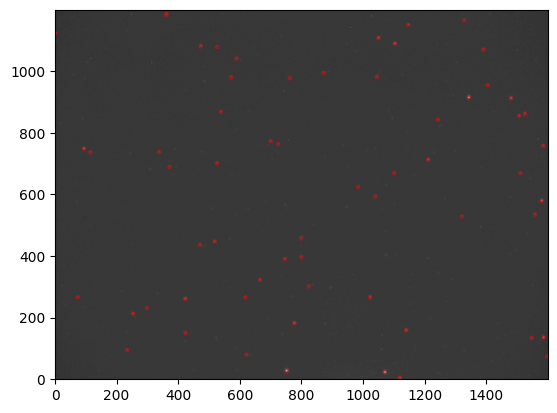

In [166]:
import numpy as np
from photutils.aperture import CircularAperture
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# Calcular la desviación estándar (ruido de fondo) de la imagen
std, median = mad_std(image_data) , np.median(image_data)

# Detectar estrellas utilizando DAOStarFinder
# Ajusta el valor del FWHM (FWHM de la PSF estimada) y el threshold (umbral de detección)
daofind = DAOStarFinder(fwhm=6.0, threshold=10.0 * std)
stars = daofind(image_data- median)
print(f"se encontraron {len(stars)} estrellas en total")

## Visualizacion de las estrellas encontradas
positions = np.transpose((stars["xcentroid"], stars["ycentroid"]))# coordenadas de las estrellas
apertures = CircularAperture(positions, r=5.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image_data, cmap="gray", origin="lower", norm=norm)
apertures.plot(color="red", lw=1, alpha=0.5);

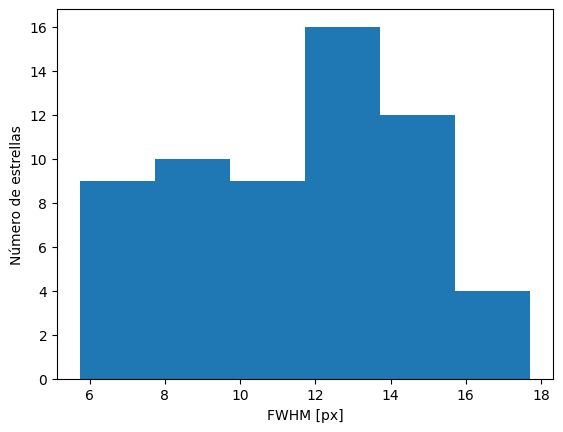

In [170]:
# Definir el ajuste Gaussiano 2D y el fitting
fit_p = fitting.LevMarLSQFitter()
diameter = []
# Calcular el FWHM para cada estrella detectada
for star in stars:
    x = star['xcentroid']
    y = star['ycentroid']
    
    # Recortar una pequeña ventana alrededor de la estrella
    size = 10  # Tamaño de la ventana (ajustable según el tamaño de las estrellas)
    x_min, x_max = int(x - size // 2), int(x + size // 2)
    y_min, y_max = int(y - size // 2), int(y + size // 2)
    
    # Si la imagen se sale de los limites en el borde no procesar
    if (x_min < 0 or x_max > image_data.shape[1] or y_min < 0 or y_max > image_data.shape[0]):
         continue

    star_cutout = image_data[y_min:y_max, x_min:x_max]

    # Crear las coordenadas (x, y) de la ventana
    yy, xx = np.mgrid[:star_cutout.shape[0], :star_cutout.shape[1]]
    
    # Ajustar una Gaussiana 2D al perfil de la estrella
    initial_guess = models.Gaussian2D(amplitude=np.max(star_cutout), x_mean=size//2, y_mean=size//2, x_stddev=1, y_stddev=1)
    fitted_model = fit_p(initial_guess, xx, yy, star_cutout)

    # Obtener los sigma en las direcciones x e y
    sigma_x = fitted_model.x_fwhm
    sigma_y = fitted_model.y_fwhm
   
    # Convertir sigma a FWHM
    a =  sigma_x
    b =  sigma_y
    #fwhm = 2*np.sqrt(np.log(2)*(a**2 + b**2))
    fwhm = np.min([a,b])
    diameter.append(fwhm)
    
    """Visualizzar resultado
    
    print(f"Estrella con FWHM (diametro) = {fwhm:.2f}")
    plt.imshow(star_cutout, origin='lower', cmap='gray', interpolation='nearest')
    plt.contour(fitted_model(xx, yy), colors='red', levels=[0.6*np.max(fitted_model(xx, yy))])
    plt.show()
     
    #"""
    
plt.hist(diameter, bins=6)
plt.xlabel("FWHM [px]")
plt.ylabel("Número de estrellas")
plt.show()

In [171]:
# Calcular la media y la desviación estándar del diametro
mean_d, median_d, std_d = np.mean(diameter), np.median(diameter), mad_std(diameter)
print(f"Los parámetros estadísticos de los diámetros encontrados para {len(stars)} estrellas  son:")
print("....")
print(f"Promedio: {mean_d:.2f}")
print("....")
print(f"Mediana: {median_d:.2f}")
print("....")
print(f"Desviación estandar: {std_d:.2f}")

Los parámetros estadísticos de los diámetros encontrados para 62 estrellas  son:
....
Promedio: 11.56
....
Mediana: 12.05
....
Desviación estandar: 3.59


## Comparación métodos

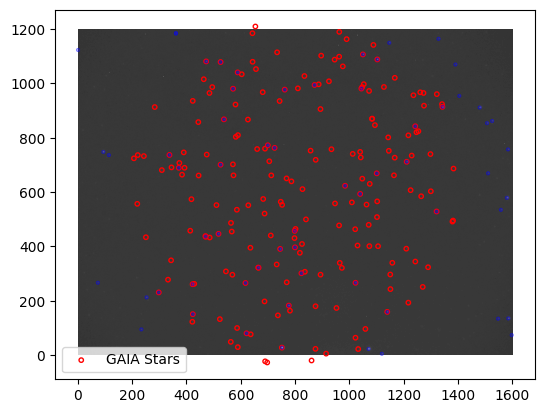

In [141]:
# GAIA
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image_data, cmap="gray", norm=norm, origin="lower")  # Usar PowerNorm para el escalado logarítmico
plt.scatter(x_star, y_star, s=10, edgecolor="red", facecolor="none", label="GAIA Stars")  # Ajustar el tamaño y color de los puntos
# DAOStarfinder
apertures.plot(color="blue", lw=1, alpha=0.5);
plt.legend()
plt.show()